[[109, 290], [841, 83], [1010, 383], [218, 616]]
[[0, 0], [825, 0], [825, 344], [0, 344]]


0

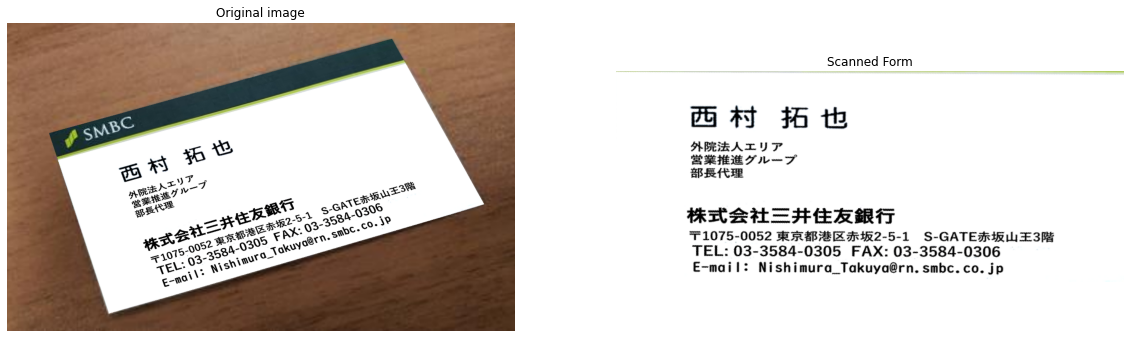

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
	'''Rearrange coordinates to order: 
       top-left, top-right, bottom-right, bottom-left'''
	rect = np.zeros((4, 2), dtype='float32')
	pts = np.array(pts)
	s = pts.sum(axis=1)
	# Top-left point will have the smallest sum.
	rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
	rect[2] = pts[np.argmax(s)]
	
	diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
	rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
	rect[3] = pts[np.argmax(diff)]
	# Return the ordered coordinates.
	return rect.astype('int').tolist()

def ImageToTrimImage():#画像ファイルをトリム画像にする
    imageFilePath ="image/namecard.png"
    img = cv2.imread(imageFilePath, cv2.IMREAD_COLOR)
    
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

    # Making Copy of original image.
    orig_img = img.copy()
    
    ## Repeated Closing operation to remove text from the document. #
    #kernel = np.ones((5,5),np.uint8)
    #img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (20,20,img.shape[1]-20,img.shape[0]-20)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    
    # Edge Detection.
    canny = cv2.Canny(gray, 100, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
    
    # Blank canvas.
    con = np.zeros_like(img)
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
    
    # Blank canvas.
    con = np.zeros_like(img)
    # Loop over the contours.
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        if len(corners) == 4:
            break
    cv2.drawContours(con, c, -1, (0, 255, 255), 3)
    cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())

    # Displaying the corners.
    for index, c in enumerate(corners):
        character = chr(65 + index)
        cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5, cv2.LINE_AA)

    # Rearranging the order of the corner points.
    corners = order_points(corners)

    print(corners)
    
    (tl, tr, br, bl) = corners
    
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Final destination co-ordinates.
    destination_corners = [
            [0, 0],
            [maxWidth, 0],
            [maxWidth, maxHeight],
            [0, maxHeight]]
    print(destination_corners)
    
    # Getting the homography.
    homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    # cv2.imwrite('grabcutop/img22.jpg', final)
    # Display results 
    plt.figure(figsize=[20,10]); 
    plt.subplot(121); plt.imshow(orig_img[:,:,::-1]); plt.axis('off'); plt.title("Original image")
    plt.subplot(122); plt.imshow(final[:,:,::-1]); plt.axis('off'); plt.title("Scanned Form");
    return 0


ImageToTrimImage()

In [15]:
def order_points(pts):
	'''Rearrange coordinates to order: 
       top-left, top-right, bottom-right, bottom-left'''
	rect = np.zeros((4, 2), dtype='float32')
	pts = np.array(pts)
	s = pts.sum(axis=1)
	# Top-left point will have the smallest sum.
	rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
	rect[2] = pts[np.argmax(s)]
	
	diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
	rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
	rect[3] = pts[np.argmax(diff)]
	# Return the ordered coordinates.
	return rect.astype('int').tolist()

In [13]:
imageFilePath ="image/namecard.png"

In [14]:
#デバグ

img = cv2.imread(imageFilePath, cv2.IMREAD_COLOR)
cv2.imshow("image.png",img)
cv2.waitKey(0)
cv2.destroyAllWindows()